# This notebook is a sole place where data analysis is done
### The cell below includes parsing util

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import re
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'


# ----------------- Parsing utils ----------------
def parse_ss_output(filename):
    '''# Function to parse the ss -tni data from a text file'''
    ESTAB_REGEX = r"ESTAB 0\s+(\d+)"
    # Load data
    with open(filename, "r") as file:
        lines = file.readlines()

    # Data dictionary for storage
    data = {
        "timestamp": [],
        "cwnd": [],
        "bytes_sent": [],
        "rtt": [],
        "ssthresh" : [],
    }

    i = 0
    while i < len(lines):
        # Skip to the next "---------"
        if "-----" in lines[i]:
            i += 1  # Skip this line
            if i >= len(lines):
                break
            
            # Parse timestamp
            timestamp_match = re.match(r"^Timestamp: (.+)", lines[i])
            if timestamp_match:
                timestamp = datetime.strptime(timestamp_match.group(1), "%Y-%m-%d %H:%M:%S.%f")
                i += 2  # Move to the next line to check for "ESTAB"

                if i < len(lines) and re.match(ESTAB_REGEX, lines[i]):
                    estab_match = re.match(ESTAB_REGEX, lines[i])
                    recv_q_value = int(estab_match.group(1)) if estab_match else 0
                    if recv_q_value>0:
                        i += 1  # Move to the data line
                        if i < len(lines) and ("bbr" in lines[i] or "cubic" in lines[i]):
                            line = lines[i]

                            # Extract cwnd
                            cwnd_match = re.search(r"cwnd:(\d+)", line)
                            cwnd = int(cwnd_match.group(1)) if cwnd_match else None

                            # Extract bytes_sent
                            bytes_sent_match = re.search(r"bytes_sent:(\d+)", line)
                            bytes_sent = int(bytes_sent_match.group(1)) if bytes_sent_match else None

                            # Extract RTT
                            rtt_match = re.search(r"rtt:(\d+\.\d+)", line)
                            rtt = float(rtt_match.group(1)) if rtt_match else None

                            # Extra ssthresh (if it exists!). 
                            ssthresh_match = re.search(r"ssthresh:(\d+)", line)
                            if ssthresh_match:
                                ssthresh = int(ssthresh_match.group(1))
                            else :
                                ssthresh = None

                            # Append to the data dictionary
                            data["timestamp"].append(timestamp)
                            data["cwnd"].append(cwnd)
                            data["bytes_sent"].append(bytes_sent)
                            data["rtt"].append(rtt)
                            data["ssthresh"].append(ssthresh)
                    else :
                        i+=2
                        if i < len(lines) and re.match(ESTAB_REGEX, lines[i]):
                            estab_match = re.match(ESTAB_REGEX, lines[i])
                            recv_q_value = int(estab_match.group(1)) if estab_match else 0

                            if recv_q_value > 0:
                                i += 1  # Move to the data line
                                if i < len(lines) and ("bbr" in lines[i] or "cubic" in lines[i]):
                                    line = lines[i]

                                    # Extract cwnd
                                    cwnd_match = re.search(r"cwnd:(\d+)", line)
                                    cwnd = int(cwnd_match.group(1)) if cwnd_match else None

                                    # Extract bytes_sent
                                    bytes_sent_match = re.search(r"bytes_sent:(\d+)", line)
                                    bytes_sent = int(bytes_sent_match.group(1)) if bytes_sent_match else None

                                    # Extract RTT
                                    rtt_match = re.search(r"rtt:(\d+\.\d+)", line)
                                    rtt = float(rtt_match.group(1)) if rtt_match else None

                                    # Extra ssthresh (if it exists!). 
                                    ssthresh_match = re.search(r"ssthresh:(\d+)", line)
                                    if ssthresh_match:
                                        ssthresh = int(ssthresh_match.group(1))
                                    else :
                                        ssthresh = None

                                    # Append to the data dictionary
                                    data["timestamp"].append(timestamp)
                                    data["cwnd"].append(cwnd)
                                    data["bytes_sent"].append(bytes_sent)
                                    data["rtt"].append(rtt)
                                    data["ssthresh"].append(ssthresh)
        
        i += 1  # Move to the next line

    df = pd.DataFrame(data)

    # Post-process data
    # Convert timestamp to seconds, starting at second 0
    df["timestamp"] = (df["timestamp"] - df["timestamp"].min()).dt.total_seconds()

    # bytes sent is cumulative, convert to non-cumulative
    df["bytes_sent"] = df["bytes_sent"].diff().fillna(0)


    # Convert bytes_sent to Gbps
    df["GBs_sent"] = df["bytes_sent"] * 8 / 1e9
    df["MBs_sent"] = df["bytes_sent"] / 1e6

    return df


# Example Usage
# filename = "../data/Cubic_0_BulkTraffic.txt"  # Replace with your file path
# filename = "../data/BBR_0_BulkTraffic.txt"  # Replace with your file path
# data = parse_ss_output(filename)
# print(data)

### The cell below includes other utils (such as get filename)



In [2]:
import os 
import json

FOLDER_NAME = "../data"
def get_filename(algorithm_name, loss_rate, application_type):
    assert algorithm_name in ["BBR", "Cubic"], 'Algorithm name must be either "BBR" or "Cubic"'
    assert loss_rate in [0, 0.01, 0.005], 'Loss rate must be 0, 0.01, or 0.005'
    assert application_type in ["BulkTraffic", "Website"], 'Application type must be either "BulkTraffic" or "Website"'
    filename =  f'{algorithm_name}_{loss_rate}_{application_type}.txt'
    filename = f'{FOLDER_NAME}/{filename}'
    assert os.path.exists(filename), f'File {filename} does not exist'
    return filename

### The cell below includes graphing functions
These are used to compare performance of BBR vs Cubic in different scenarios

In [25]:
# Constants for font sizes
FONT_SIZE_TITLE = 16
FONT_SIZE_LABEL = 14
FONT_SIZE_TICKS = 12
FONT_SIZE_LEGEND = 12
FONT_SIZE_GRAPH_TITLE = 18

def get_and_pre_process_data_for_graphing(application_type, loss_rate, limit_x_axis_timestamp=False, smoothen_data_rate=False):
    # 1. Get data
    algorithm_name1, algorithm_name2 = "BBR", "Cubic"
    filename1 = get_filename(algorithm_name1, loss_rate, application_type)
    filename2 = get_filename(algorithm_name2, loss_rate, application_type)
    data1 = parse_ss_output(filename1)
    data2 = parse_ss_output(filename2)

    # 2. Data pre-processing
    if limit_x_axis_timestamp:
        data1 = data1[data1.timestamp < limit_x_axis_timestamp]
        data2 = data2[data2.timestamp < limit_x_axis_timestamp]
    
    assert smoothen_data_rate is False or smoothen_data_rate > 0, 'smoothen_data_rate must be None or a positive integer'
    if smoothen_data_rate:
        for col in ['MBs_sent', 'GBs_sent', 'cwnd', 'rtt', 'ssthresh']:
            data1[col] = data1[col].rolling(window=smoothen_data_rate).mean()
            data2[col] = data2[col].rolling(window=smoothen_data_rate).mean()

    # if value off sthresh is bigger than 1k set it to 0
    data1.loc[data1['ssthresh'] > 2000, 'ssthresh'] = 0
    data2.loc[data2['ssthresh'] > 2000, 'ssthresh'] = 0

    return data1, data2

def graph_compare(attribute, y_label, application_type, limit_x_axis_timestamp=False, smoothen_data_rate=False, title = None):
    fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
    
    # Add delay information to the title based on application_type
    # delay_info = "(no delay)" if application_type == "Website" else "(delay 20ms)" if application_type == "BulkTraffic" else ""
    if title is None: # if we don't overwrite the title, set it to the default
        title = f"Comparison of {y_label} for {application_type} (delay 20ms)"
    
    for i, loss_rate in enumerate([0, 0.005, 0.01]):
        data1, data2 = get_and_pre_process_data_for_graphing(application_type, loss_rate, limit_x_axis_timestamp, smoothen_data_rate)
        axs[i].plot(data1.timestamp, data1[attribute], label="BBR")
        axs[i].plot(data2.timestamp, data2[attribute], label="Cubic")
        axs[i].set_title(f"Loss rate {loss_rate}", fontsize=FONT_SIZE_TITLE)
        axs[i].set_xlabel("Time (s)", fontsize=FONT_SIZE_LABEL)
        axs[i].tick_params(axis='both', which='major', labelsize=FONT_SIZE_TICKS)
    
    # Set shared y-axis label
    fig.text(-0.02, 0.5, y_label, va='center', rotation='vertical', fontsize=FONT_SIZE_LABEL)
    
    # Set graph title
    fig.suptitle(title, fontsize=FONT_SIZE_GRAPH_TITLE, fontweight='bold')

    # Create a single shared legend
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=FONT_SIZE_LEGEND, bbox_to_anchor=(0.5, 1.1))

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

def graph_compare_throughput(application_type, limit_x_axis_timestamp=False, smoothen_data_rate=False):
    graph_compare("MBs_sent", "Throughput (Mbps)", application_type, limit_x_axis_timestamp, smoothen_data_rate)

def graph_compare_cwnd(application_type, limit_x_axis_timestamp=False, smoothen_data_rate=False):
    graph_compare("cwnd", "CWND (nr packets)", application_type, limit_x_axis_timestamp, smoothen_data_rate)

def graph_compare_rtt(application_type, limit_x_axis_timestamp=False, smoothen_data_rate=False):
    graph_compare("rtt", "RTT (ms)", application_type, limit_x_axis_timestamp, smoothen_data_rate)

def graph_compare_sstresh(application_type, limit_x_axis_timestamp=False, smoothen_data_rate=False):
    graph_compare("ssthresh", "SSThresh", application_type, limit_x_axis_timestamp, smoothen_data_rate)


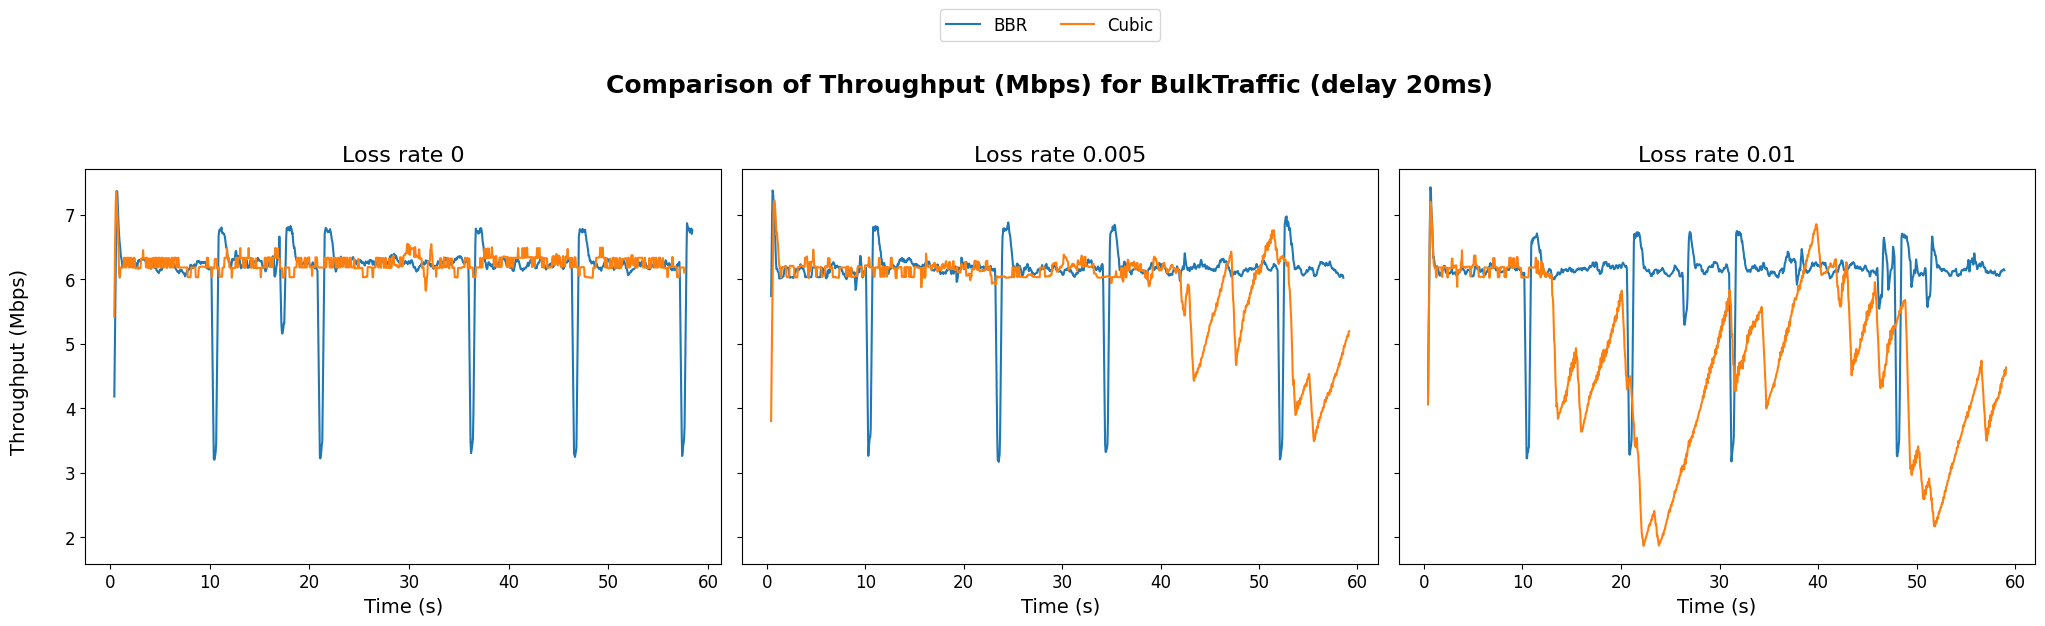

In [26]:
graph_compare_throughput("BulkTraffic", limit_x_axis_timestamp = 100, smoothen_data_rate = 10)

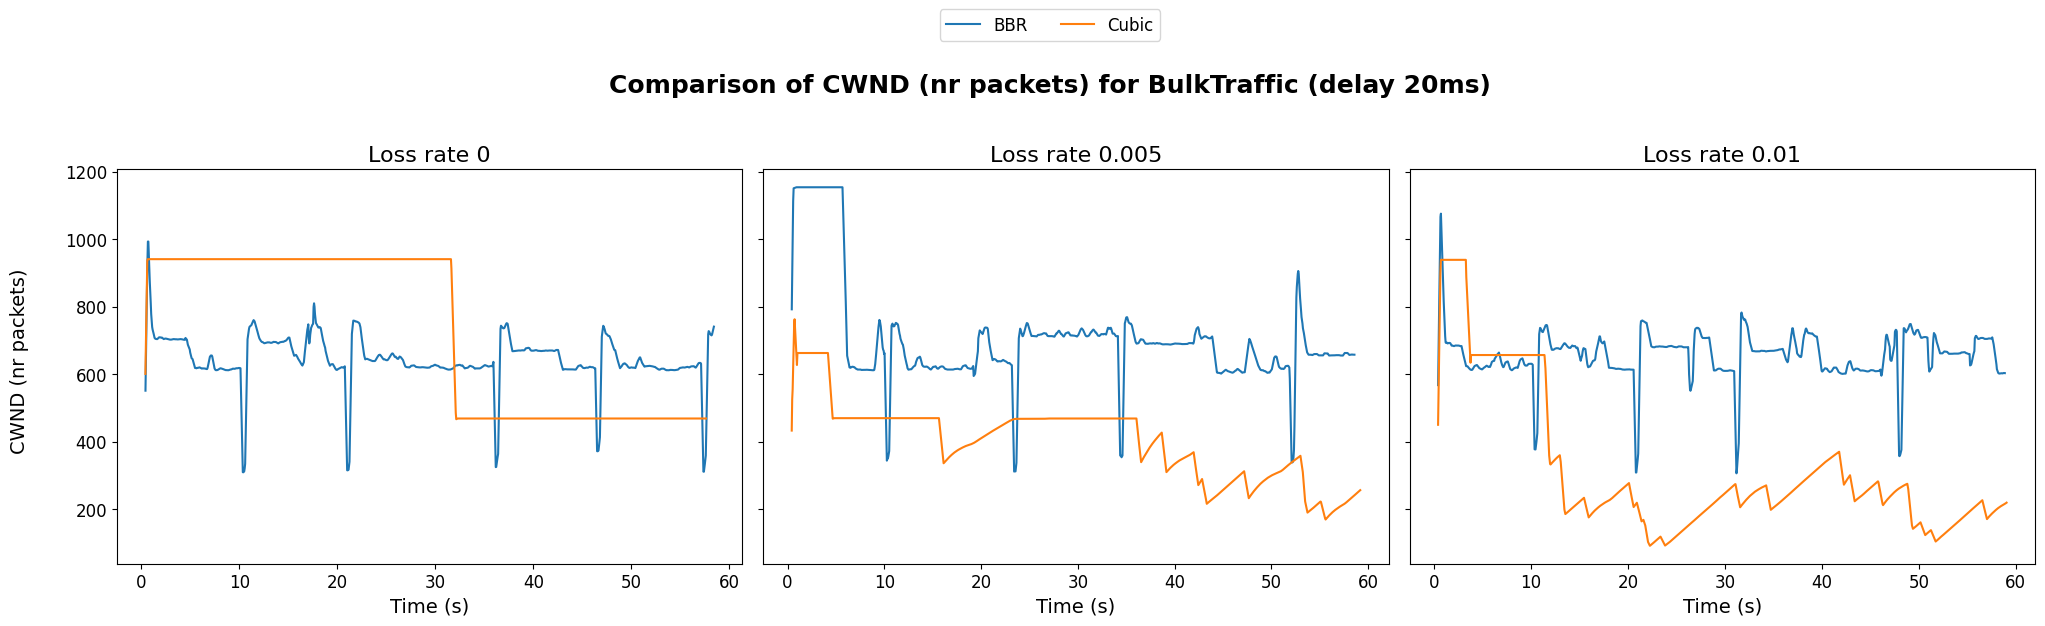

In [27]:
graph_compare_cwnd("BulkTraffic", limit_x_axis_timestamp = 100, smoothen_data_rate = 10)

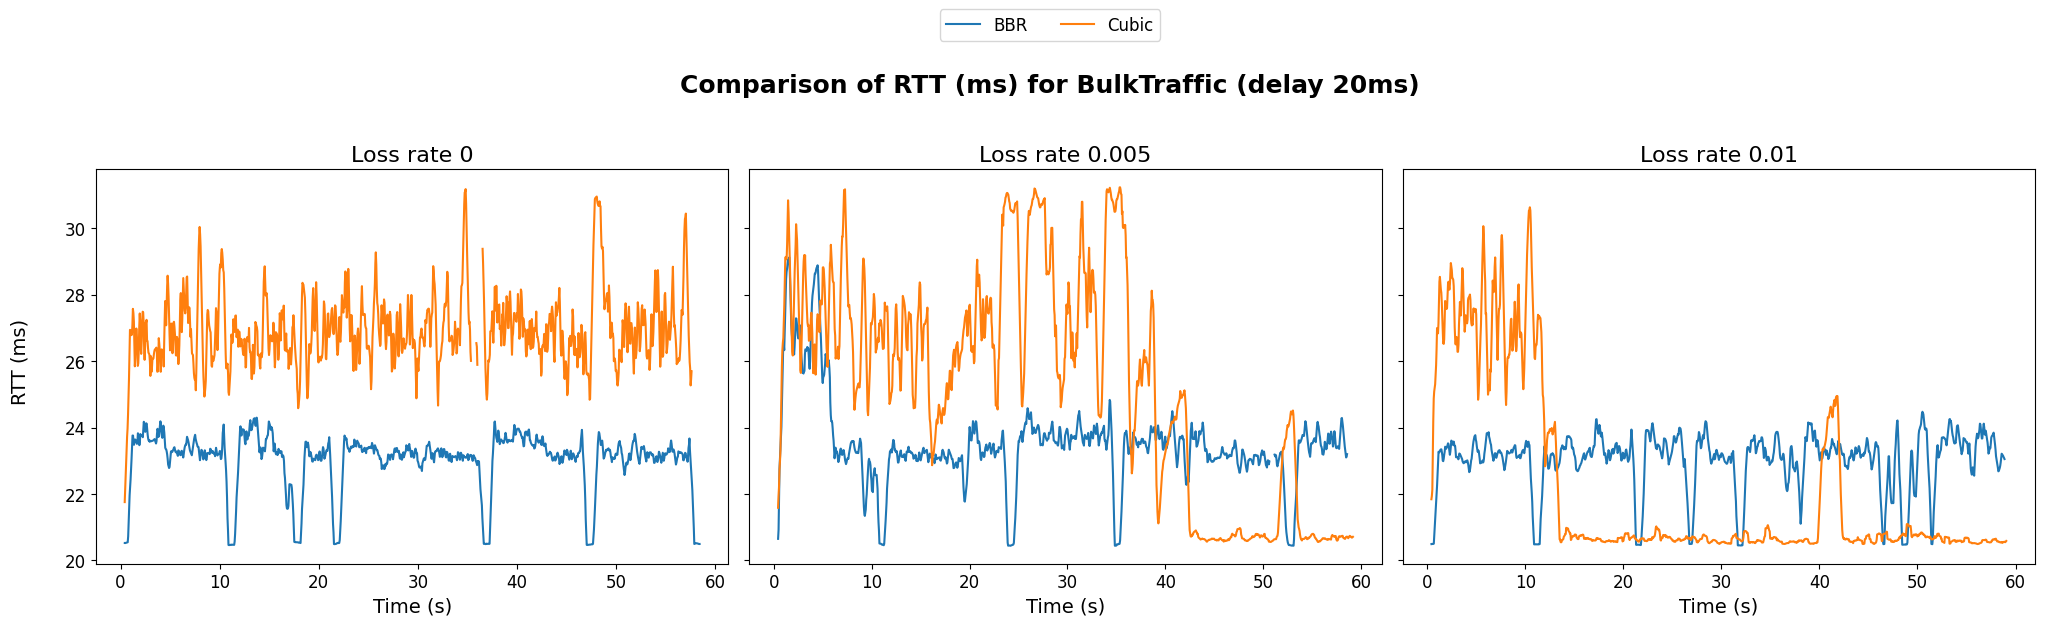

In [28]:
graph_compare_rtt("BulkTraffic", limit_x_axis_timestamp = 100, smoothen_data_rate = 10)

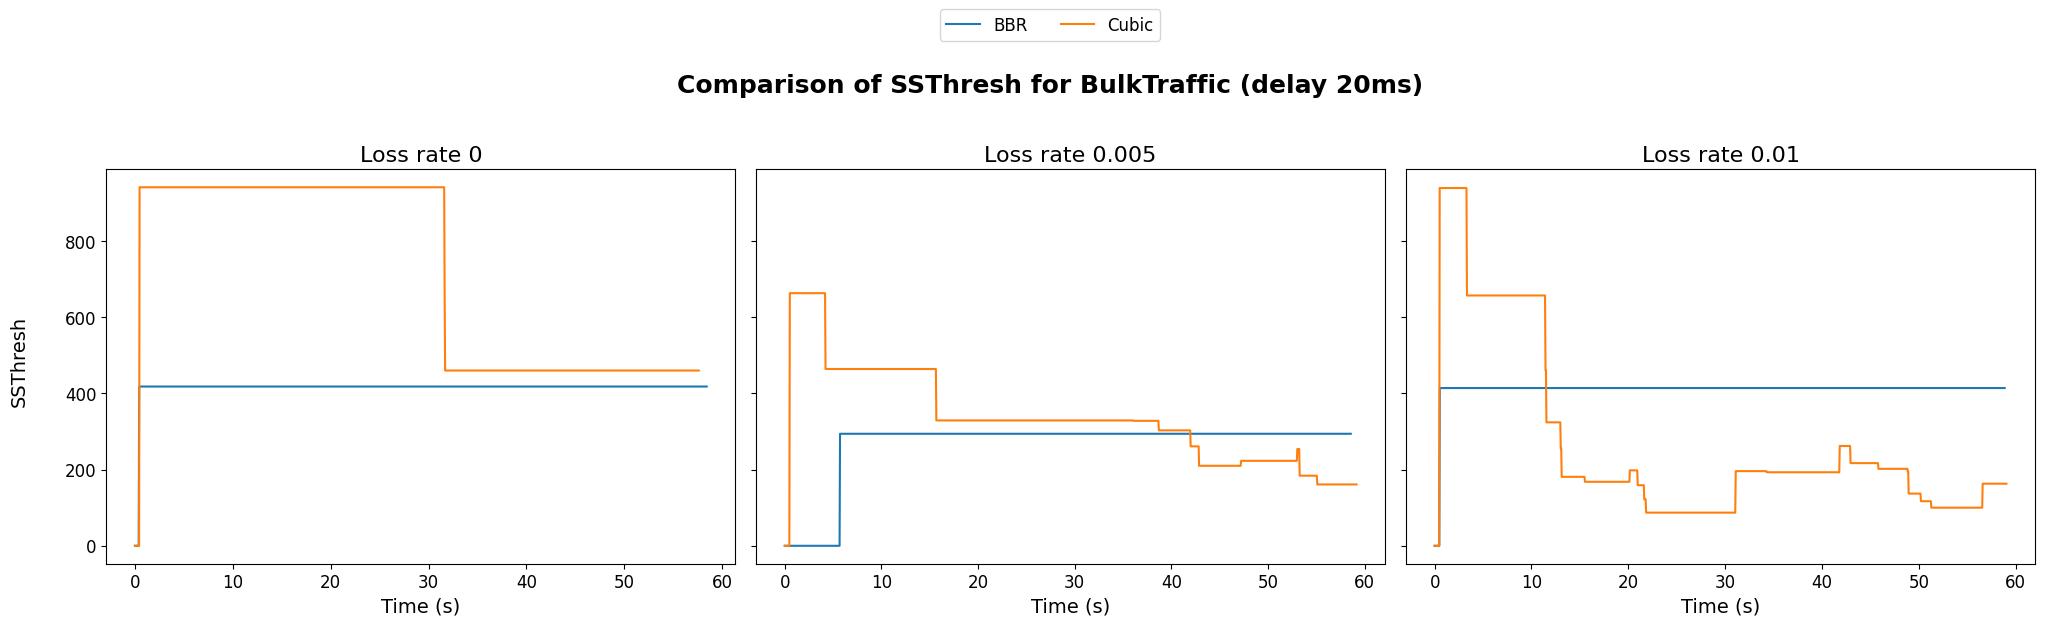

In [31]:
graph_compare_sstresh("BulkTraffic", limit_x_axis_timestamp = 100, smoothen_data_rate = 1)

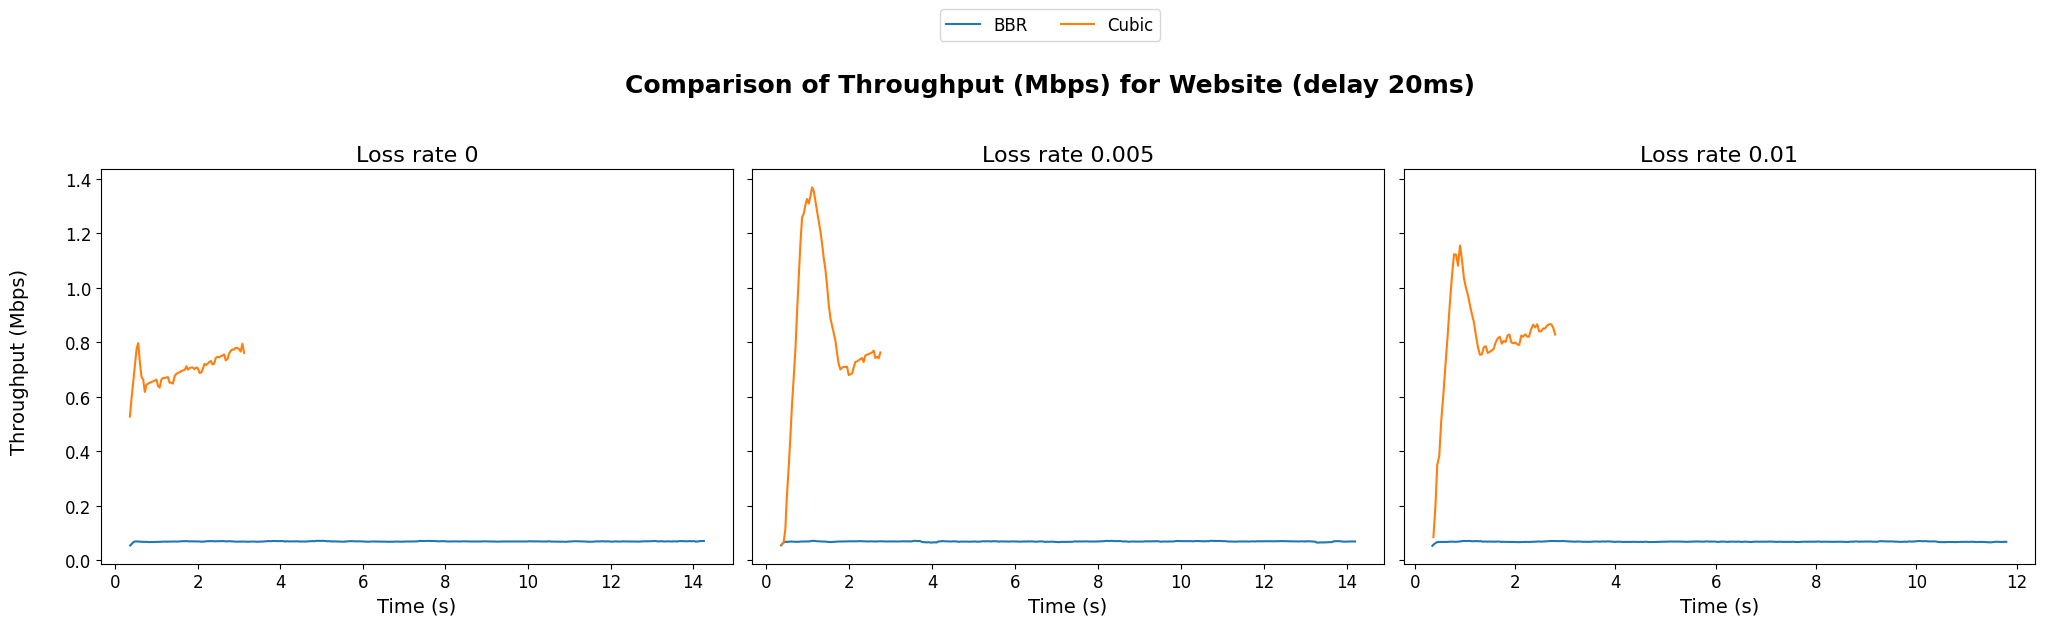

In [7]:
graph_compare_throughput("Website", limit_x_axis_timestamp = 100, smoothen_data_rate = 10)

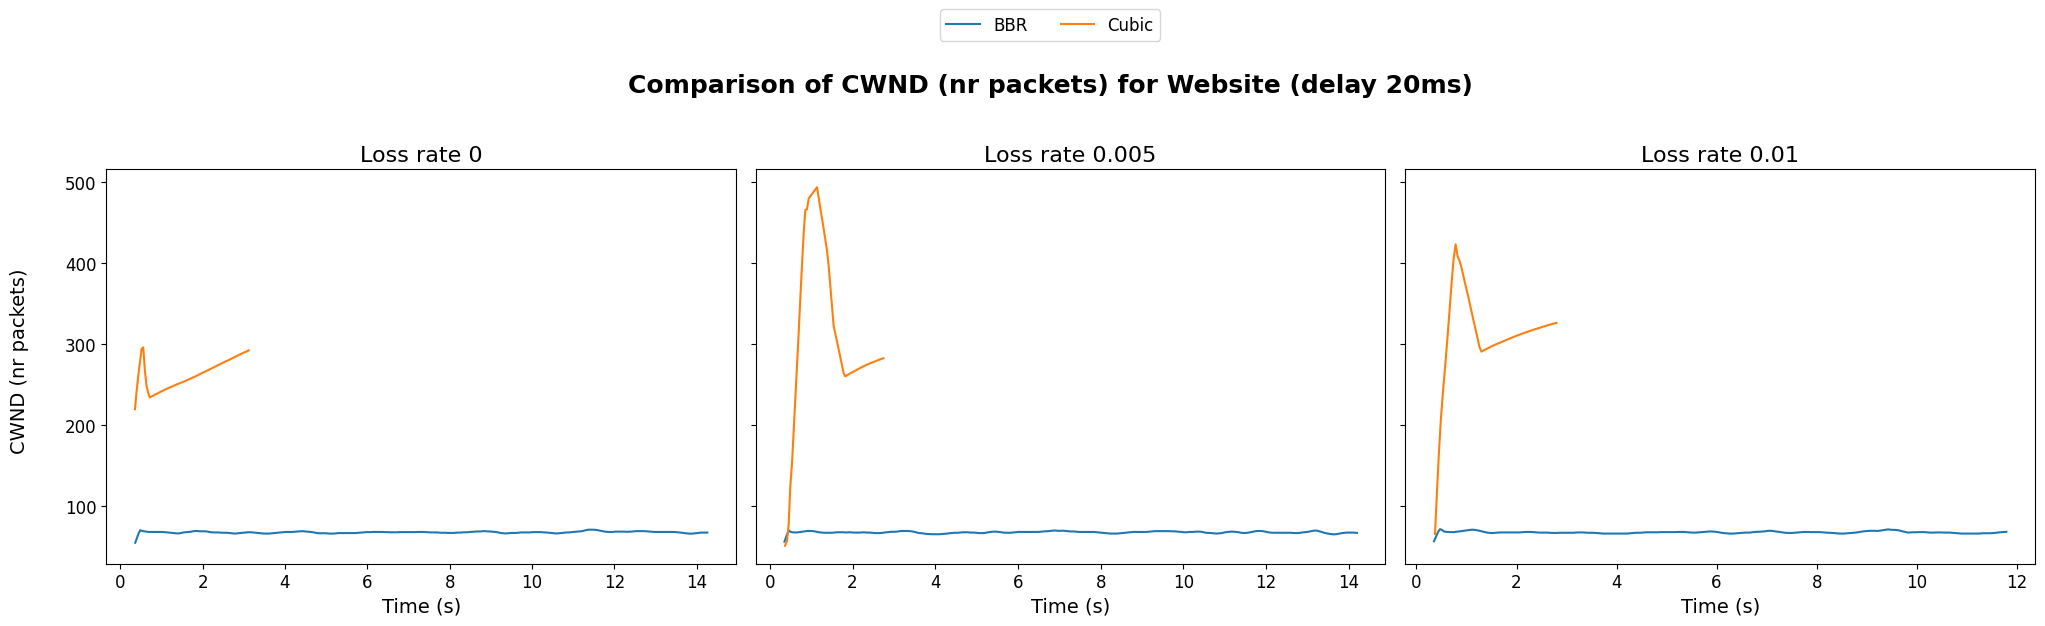

In [8]:
graph_compare_cwnd("Website", limit_x_axis_timestamp = 100, smoothen_data_rate = 10)

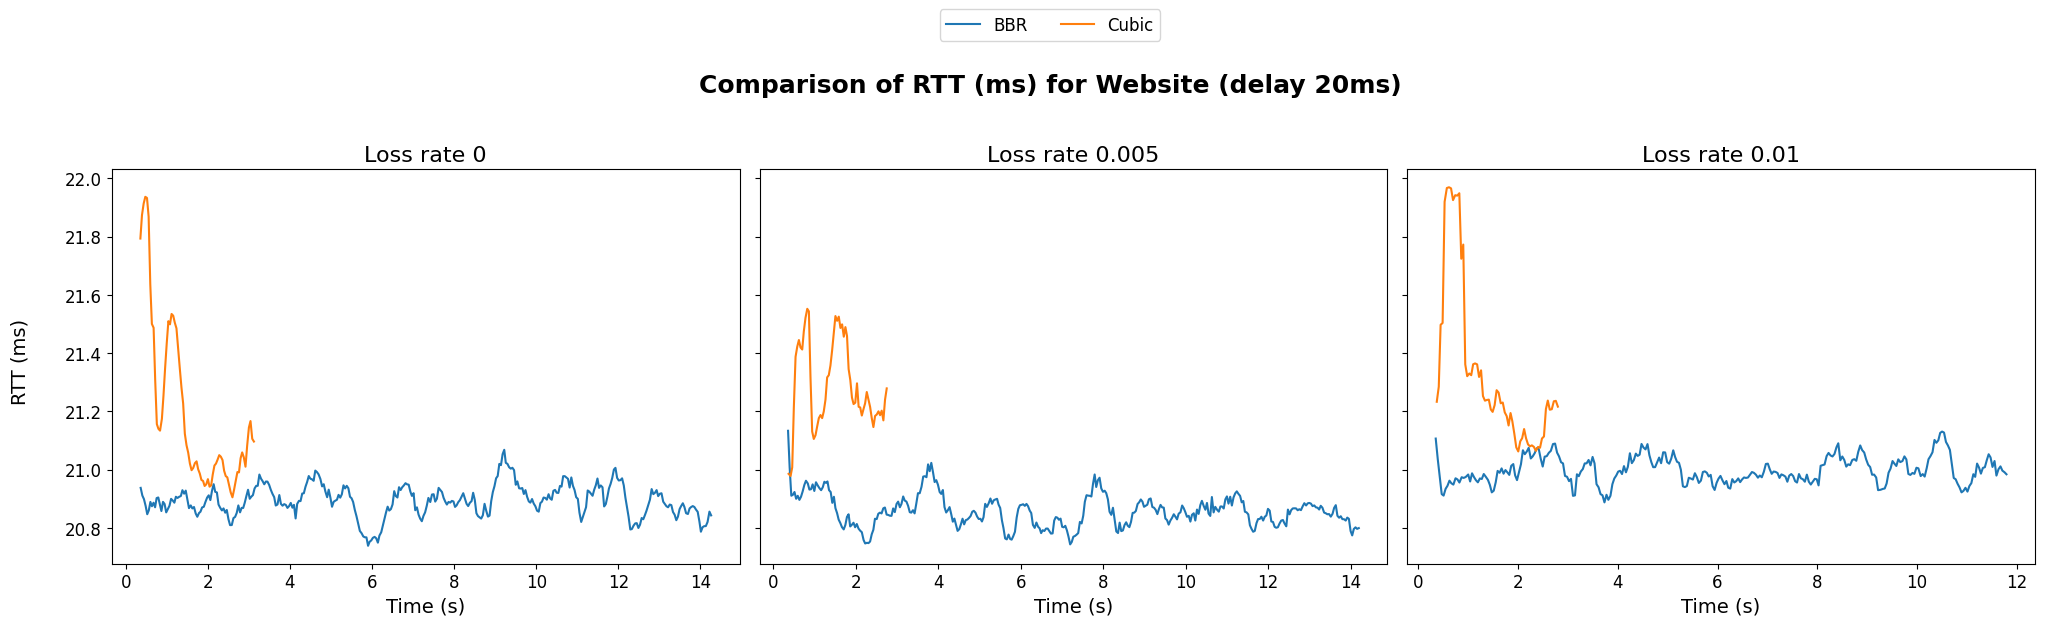

In [9]:
graph_compare_rtt("Website", limit_x_axis_timestamp = 100, smoothen_data_rate = 10)

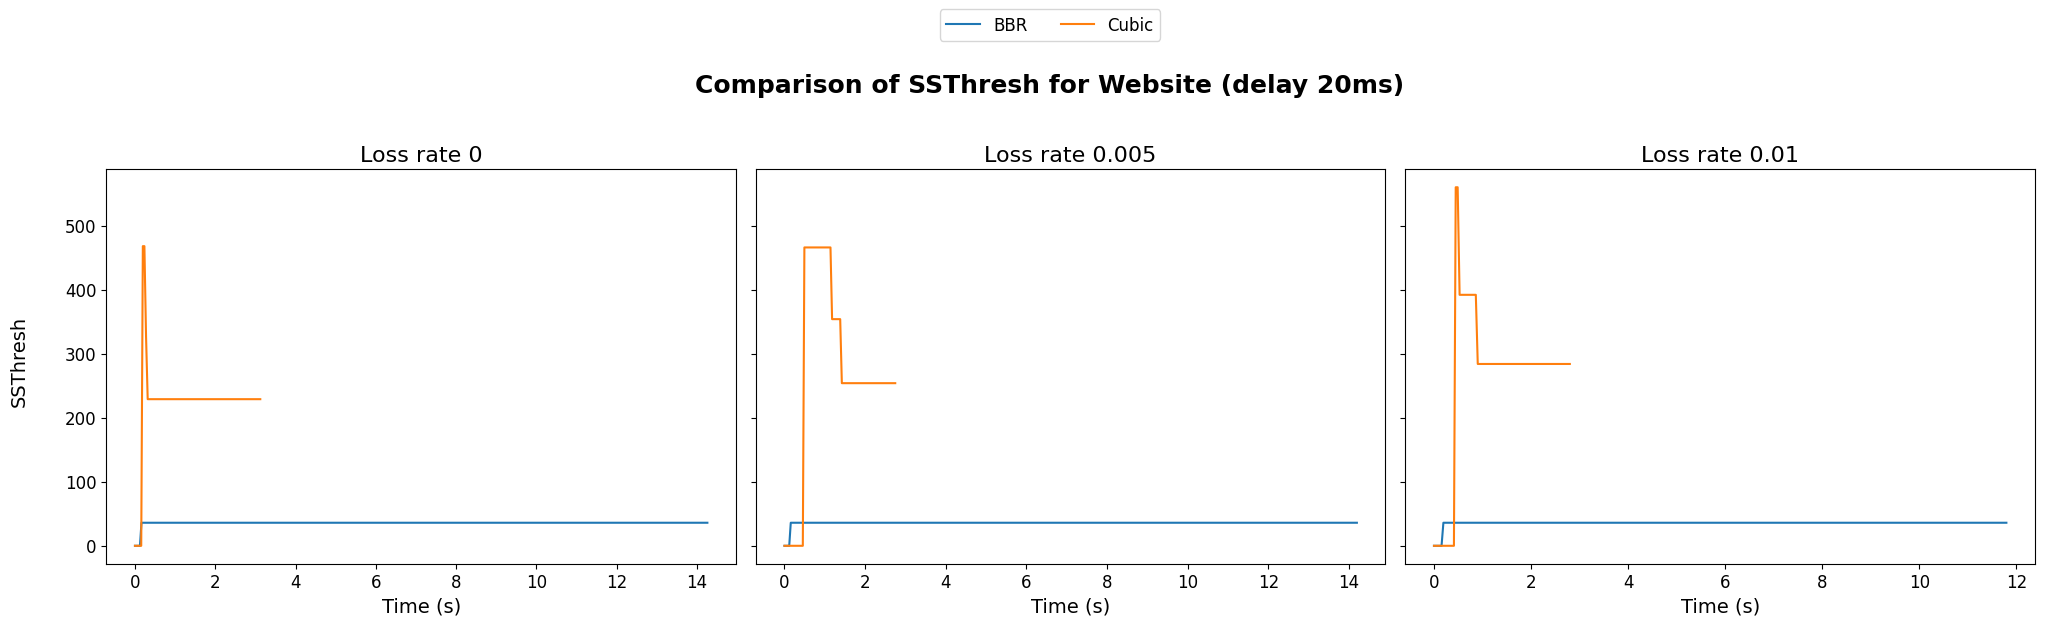

In [32]:
graph_compare_sstresh("Website", limit_x_axis_timestamp = 100, smoothen_data_rate = 1)

# Slow start ad-hoc

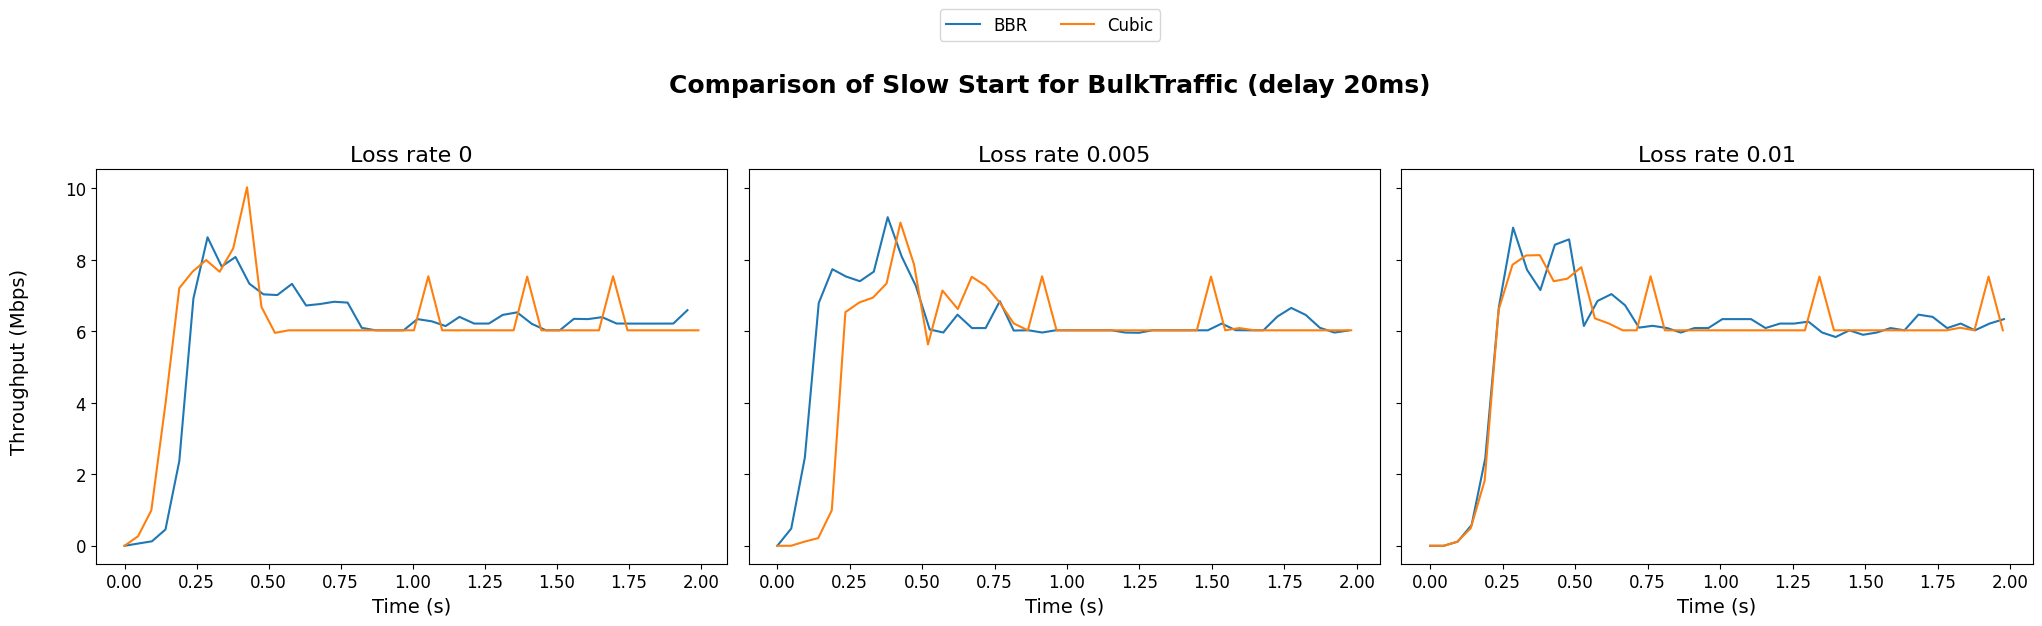

In [10]:
graph_compare("MBs_sent", "Throughput (Mbps)", "BulkTraffic", 2, 1, "Comparison of Slow Start for BulkTraffic (delay 20ms)")

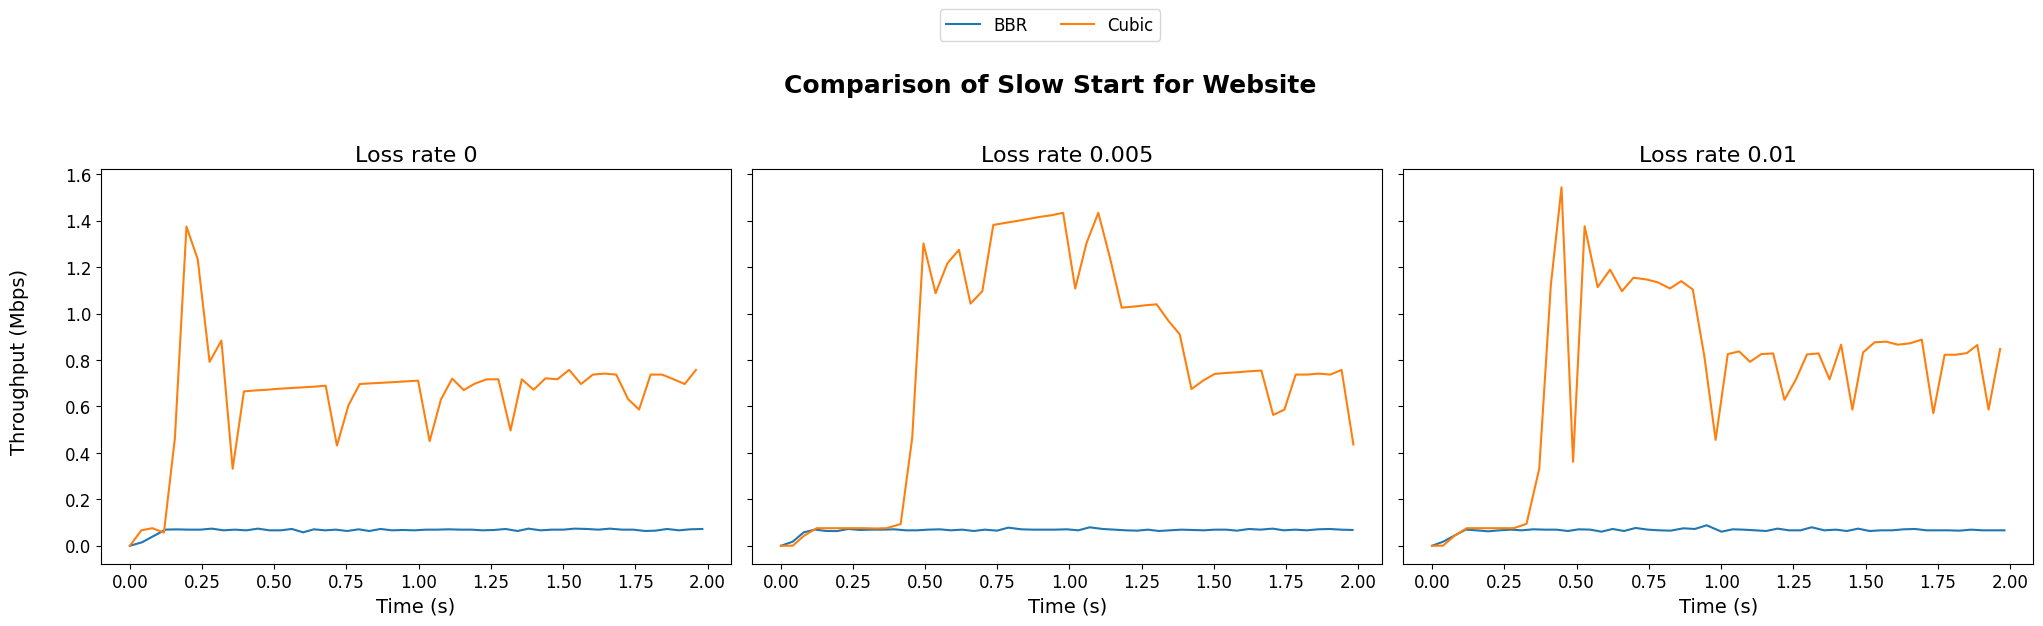

In [11]:
graph_compare("MBs_sent", "Throughput (Mbps)", "Website", 2, 1, "Comparison of Slow Start for Website")